## Run INSPIRE on adjacent MERFISH slices from mouse hypothalamic preoptic region

In this tutorial, we show INSPIRE's ability to perform spatial registration across adjacent 2D slices.

The MERFISH slices are publicly available at https://doi.org/10.5061/dryad.8t8s248.

### Import packages

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import umap
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.cm import get_cmap
from matplotlib.lines import Line2D

import INSPIRE

import warnings
warnings.filterwarnings("ignore")

### Load data

In [2]:
data_dir = "/gpfs/gibbs/project/zhao/jz874/jiazhao/reference-free_spatial-integration/data/MERFISH_mouse_hypothalamus"
spatial_data = pd.read_csv(data_dir + '/Moffitt_and_Bambah-Mukku_et_al_merfish_all_cells.csv', 
                           sep=',', index_col=0)
spatial_data = spatial_data[spatial_data.Animal_ID.values==1]

gene_exp = spatial_data[spatial_data.columns[8:]]
gene_exp = gene_exp.drop(columns = ['Blank_1','Blank_2','Blank_3','Blank_4','Blank_5','Fos'])
meta_st = spatial_data[spatial_data.columns[:8]]

Bregma_list = [-0.09, -0.04]
adata_st_list = []
for Bregma in Bregma_list:
    adata_st_i = ad.AnnData(X=gene_exp[(meta_st.Bregma.values==Bregma)].values)
    adata_st_i.obs = meta_st[(meta_st.Bregma.values==Bregma)]
    adata_st_i.var.index = gene_exp.columns
    adata_st_i.obsm['spatial'] = np.concatenate((adata_st_i.obs.Centroid_X.values.reshape(-1, 1),
                                                 adata_st_i.obs.Centroid_Y.values.reshape(-1, 1)), axis=1)
    adata_st_i = adata_st_i[adata_st_i.obs["Cell_class"].values.astype(str) != "Ambiguous", :]
    adata_st_list.append(adata_st_i)

In [3]:
theta = 0.5
R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
adata_st_list[0].obsm["spatial"] = adata_st_list[0].obsm["spatial"] @ R.T + np.array([-2000,0]).reshape((1,-1))

### Data preprocessing

Get shared genes among all datasets...
Find 155 shared genes among datasets.
Finding highly variable genes...
shape of adata 0 before quality control:  (5557, 155)
shape of adata 0 after quality control:  (5557, 155)
shape of adata 1 before quality control:  (5488, 155)
shape of adata 1 after quality control:  (5488, 155)
Find 155 shared highly variable genes among datasets.
Concatenate datasets as a full anndata for better visualization...


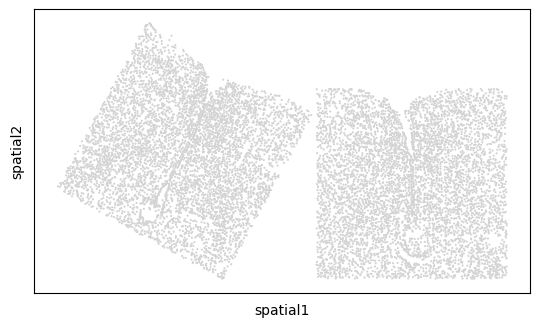

Store counts and library sizes for Poisson modeling...
Normalize data...


In [4]:
adata_st_list, adata_full = INSPIRE.utils.preprocess(adata_st_list=adata_st_list,
                                                     num_hvgs=155,
                                                     min_genes_qc=1,
                                                     min_cells_qc=1,
                                                     spot_size=20,
                                                     limit_num_genes=True)

### Build spatial graph

In [5]:
adata_st_list = INSPIRE.utils.build_graph_LGCN(adata_st_list=adata_st_list, 
                                               rad_cutoff_list=[30,30])

Start building graphs...
Build graphs and prepare node features for LGCN networks
Radius for graph connection is 30.0000.
5.0455 neighbors per cell on average.
Node features for slice 0 : (5557, 310)
Radius for graph connection is 30.0000.
4.7493 neighbors per cell on average.
Node features for slice 1 : (5488, 310)


### Run INSPIRE model

In [6]:
model = INSPIRE.model.Model_LGCN(adata_st_list=adata_st_list,
                                 n_spatial_factors=15,
                                 n_training_steps=10000,
                                 batch_size=1024,
                                 different_platforms=False
                                 )

In [7]:
model.train(adata_st_list)

  0%|          | 9/10000 [00:00<04:16, 38.90it/s]

Step: 0, d_loss: 1.4000, Loss: 502.5267, recon_loss: 244.0256, fe_loss: 39.2967, geom_loss: 37.6492, beta_loss: 217.7861, gan_loss: 0.6654


  5%|▌         | 510/10000 [00:06<02:01, 78.26it/s]

Step: 500, d_loss: 1.0193, Loss: 286.1814, recon_loss: 59.8730, fe_loss: 18.7443, geom_loss: 36.1921, beta_loss: 205.5907, gan_loss: 1.2497


 10%|█         | 1012/10000 [00:13<01:54, 78.39it/s]

Step: 1000, d_loss: 0.8270, Loss: 156.2975, recon_loss: -69.9812, fe_loss: 18.0164, geom_loss: 35.4838, beta_loss: 205.9139, gan_loss: 1.6388


 15%|█▌        | 1515/10000 [00:19<01:48, 77.94it/s]

Step: 1500, d_loss: 0.7175, Loss: 65.4151, recon_loss: -159.7491, fe_loss: 17.5807, geom_loss: 34.2849, beta_loss: 205.3083, gan_loss: 1.5895


 20%|██        | 2013/10000 [00:25<01:42, 78.24it/s]

Step: 2000, d_loss: 0.6696, Loss: 10.3022, recon_loss: -214.8081, fe_loss: 17.5326, geom_loss: 34.9369, beta_loss: 205.1512, gan_loss: 1.7278


 25%|██▌       | 2510/10000 [00:32<01:37, 76.96it/s]

Step: 2500, d_loss: 0.6163, Loss: -39.8540, recon_loss: -265.5933, fe_loss: 17.4737, geom_loss: 34.1769, beta_loss: 205.7100, gan_loss: 1.8721


 30%|███       | 3016/10000 [00:38<01:28, 78.54it/s]

Step: 3000, d_loss: 0.6094, Loss: -63.3827, recon_loss: -289.2559, fe_loss: 17.3956, geom_loss: 34.5390, beta_loss: 205.7115, gan_loss: 2.0753


 35%|███▌      | 3510/10000 [00:45<01:21, 79.40it/s]

Step: 3500, d_loss: 0.5485, Loss: -75.9593, recon_loss: -301.2336, fe_loss: 17.4896, geom_loss: 35.7058, beta_loss: 205.1676, gan_loss: 1.9030


 40%|████      | 4011/10000 [00:51<01:17, 77.08it/s]

Step: 4000, d_loss: 0.5253, Loss: -82.1392, recon_loss: -308.6772, fe_loss: 17.5401, geom_loss: 36.9257, beta_loss: 206.1226, gan_loss: 2.1367


 45%|████▌     | 4517/10000 [00:57<01:09, 79.38it/s]

Step: 4500, d_loss: 0.4958, Loss: -103.3048, recon_loss: -328.9675, fe_loss: 17.5336, geom_loss: 37.0095, beta_loss: 205.3597, gan_loss: 2.0292


 50%|█████     | 5016/10000 [01:04<01:03, 78.92it/s]

Step: 5000, d_loss: 0.5482, Loss: -95.6770, recon_loss: -321.2448, fe_loss: 17.4857, geom_loss: 37.6905, beta_loss: 205.6635, gan_loss: 1.6648


 55%|█████▌    | 5509/10000 [01:10<00:57, 77.44it/s]

Step: 5500, d_loss: 0.5527, Loss: -120.0023, recon_loss: -346.7401, fe_loss: 17.5654, geom_loss: 43.0398, beta_loss: 206.2297, gan_loss: 2.0818


 60%|██████    | 6013/10000 [01:16<00:51, 78.01it/s]

Step: 6000, d_loss: 0.4453, Loss: -106.3281, recon_loss: -333.2422, fe_loss: 17.5063, geom_loss: 46.2576, beta_loss: 206.2820, gan_loss: 2.2006


 65%|██████▌   | 6510/10000 [01:23<00:43, 79.33it/s]

Step: 6500, d_loss: 0.4188, Loss: -105.6972, recon_loss: -332.9452, fe_loss: 17.4292, geom_loss: 50.6901, beta_loss: 206.3159, gan_loss: 2.4891


 70%|███████   | 7014/10000 [01:29<00:38, 77.74it/s]

Step: 7000, d_loss: 0.3717, Loss: -115.3094, recon_loss: -342.4021, fe_loss: 17.3646, geom_loss: 52.0427, beta_loss: 206.3426, gan_loss: 2.3446


 75%|███████▌  | 7514/10000 [01:36<00:32, 77.37it/s]

Step: 7500, d_loss: 0.3684, Loss: -120.8444, recon_loss: -348.6528, fe_loss: 17.4001, geom_loss: 50.3630, beta_loss: 206.6439, gan_loss: 2.7572


 80%|████████  | 8010/10000 [01:42<00:25, 79.09it/s]

Step: 8000, d_loss: 0.3640, Loss: -127.4287, recon_loss: -354.9323, fe_loss: 17.4156, geom_loss: 51.6022, beta_loss: 206.3277, gan_loss: 2.7283


 85%|████████▌ | 8513/10000 [01:48<00:19, 78.12it/s]

Step: 8500, d_loss: 0.3448, Loss: -127.3825, recon_loss: -354.6135, fe_loss: 17.3848, geom_loss: 54.0276, beta_loss: 205.9847, gan_loss: 2.7810


 90%|█████████ | 9015/10000 [01:55<00:12, 78.72it/s]

Step: 9000, d_loss: 0.2986, Loss: -133.5987, recon_loss: -360.3921, fe_loss: 17.5265, geom_loss: 54.7743, beta_loss: 205.8454, gan_loss: 2.3260


 95%|█████████▌| 9511/10000 [02:01<00:06, 77.63it/s]

Step: 9500, d_loss: 0.3471, Loss: -115.3640, recon_loss: -343.0369, fe_loss: 17.6624, geom_loss: 56.8504, beta_loss: 206.6015, gan_loss: 2.2720


100%|██████████| 10000/10000 [02:07<00:00, 78.21it/s]


### Access spot representations, proportions of spatial factors in spots, and gene loading matrix

In [8]:
adata_full, basis_df = model.eval(adata_st_list, adata_full)
basis = np.array(basis_df.values)

Add cell/spot proportions of spatial factors into adata_full.obs...
Add cell/spot latent representations into adata_full.obsm['latent']...


Gene loading matrix is saved as basis.

### Spatial distributions of spatial factors in tissues

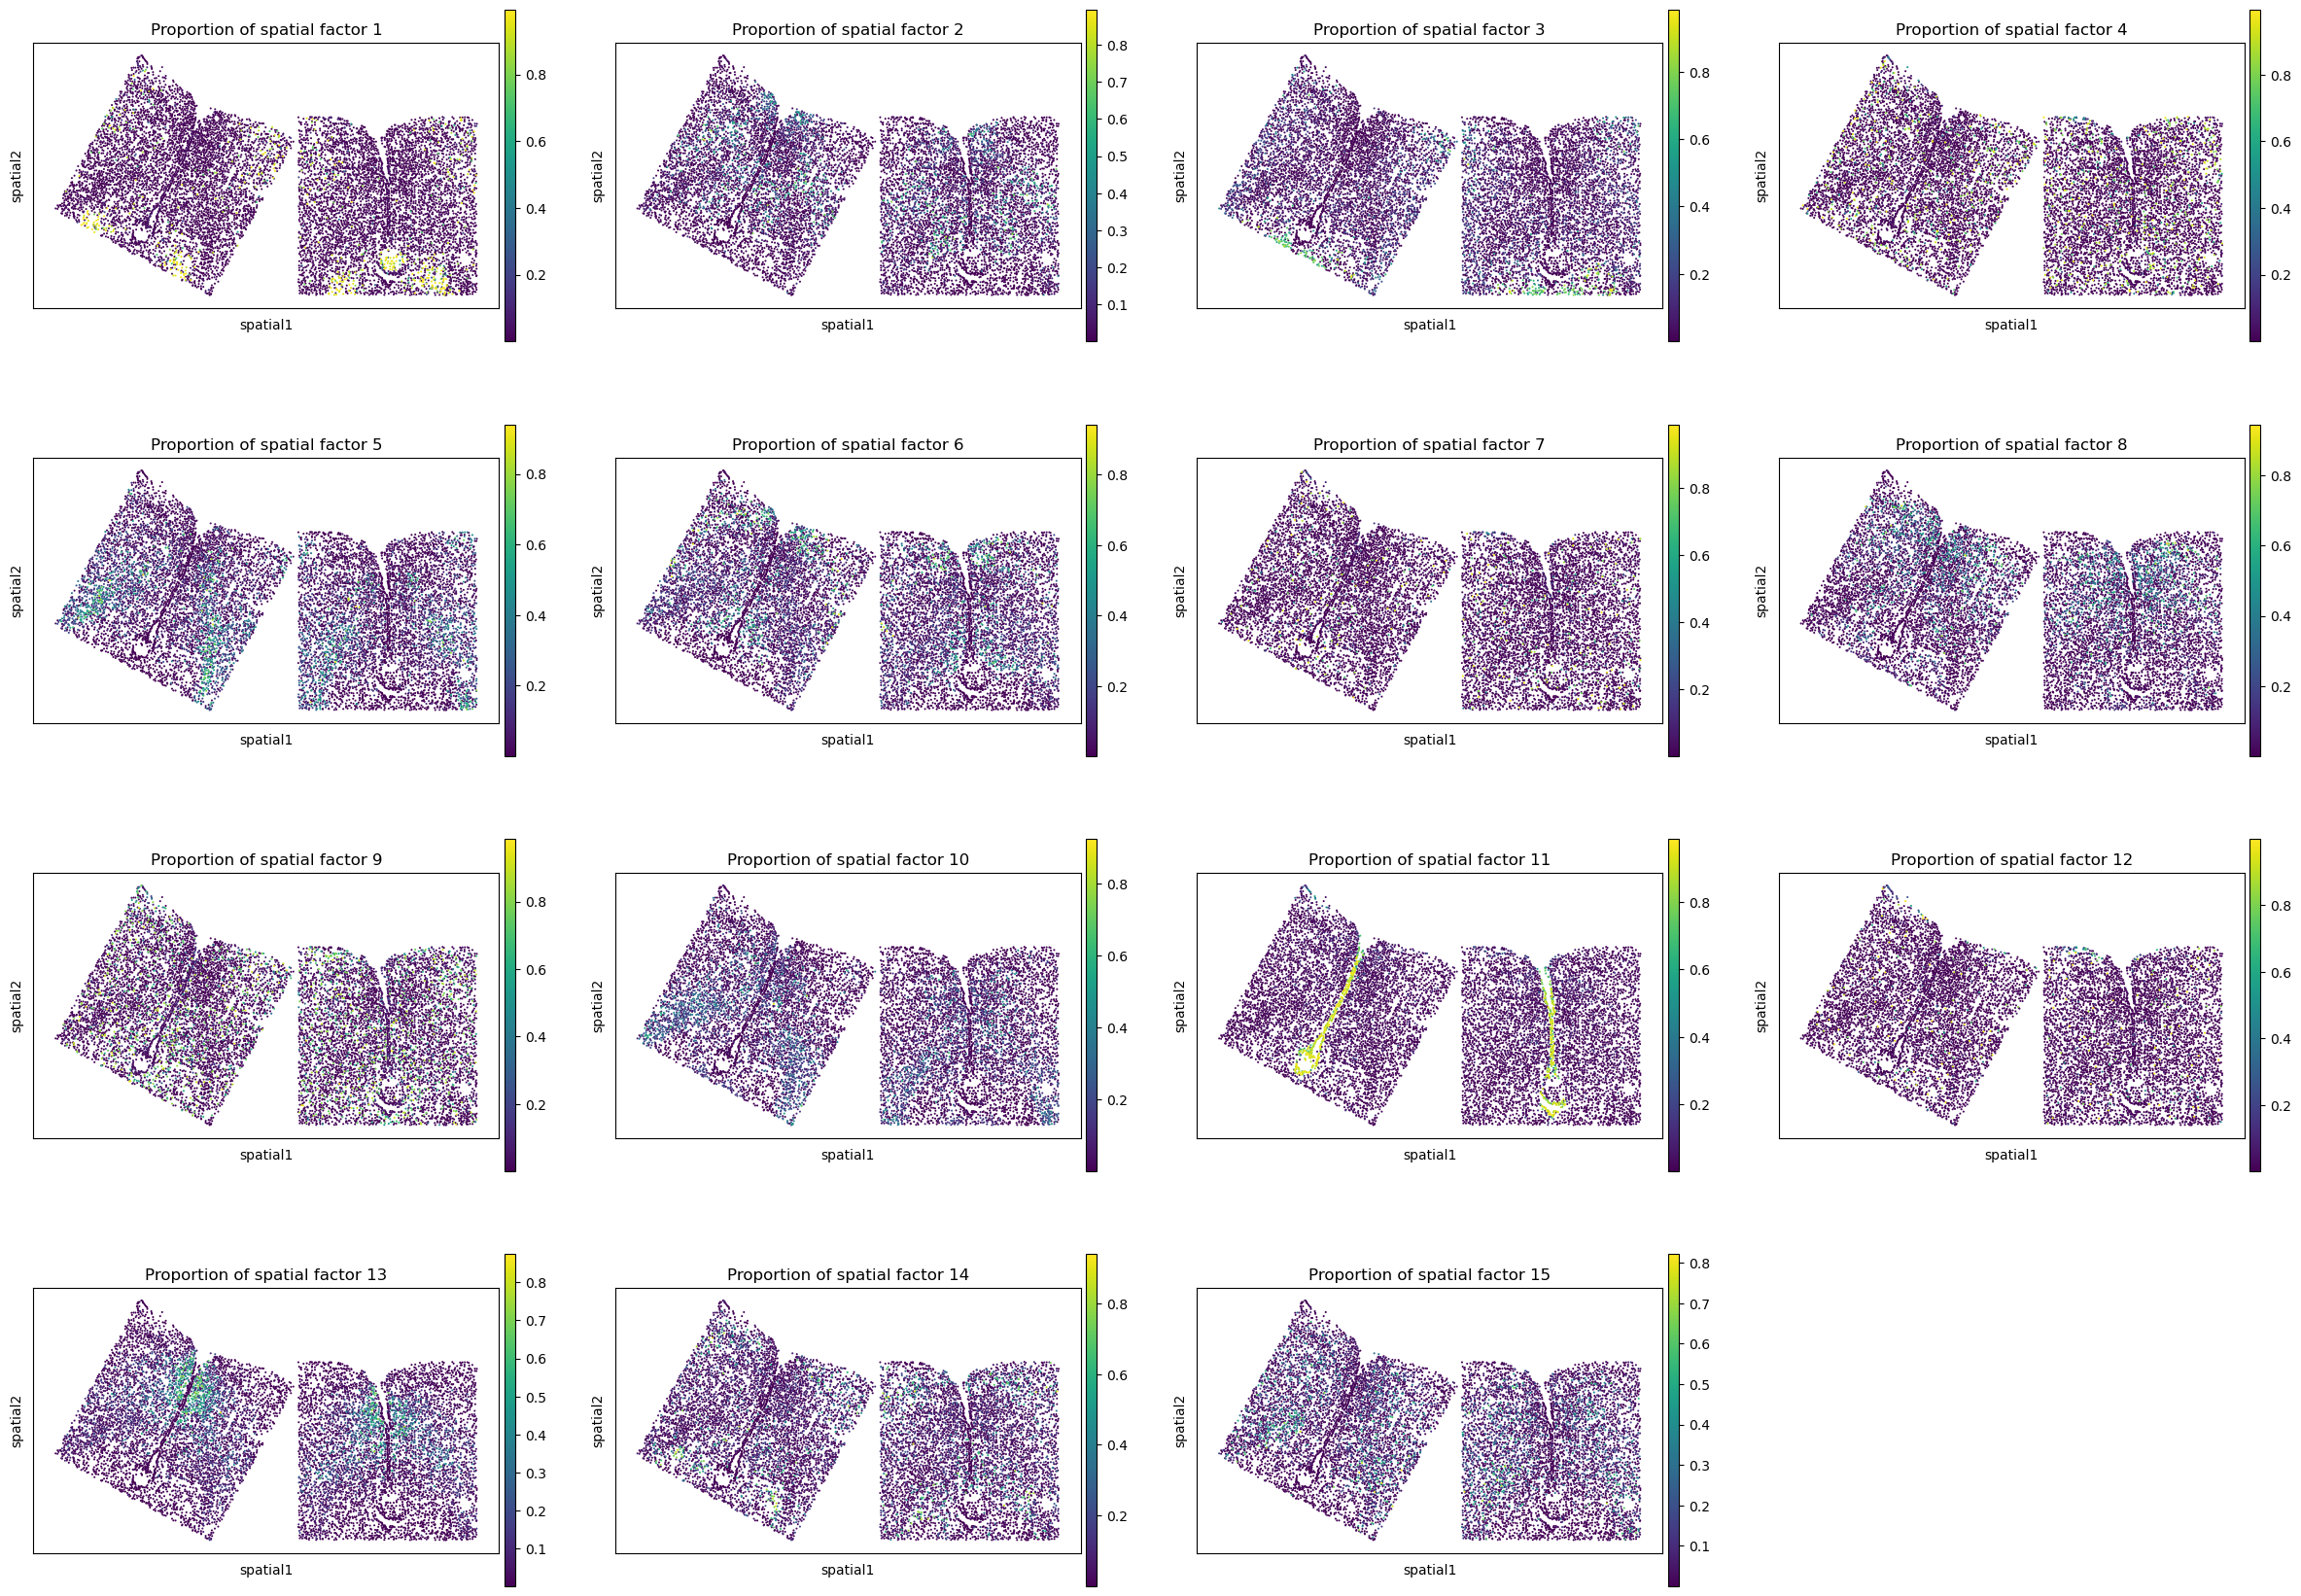

In [9]:
sc.pl.spatial(adata_full, color=["Proportion of spatial factor "+str(i+1) for i in range(15)], spot_size=20.)

### Spot representations

In [10]:
# calculate 2D UMAP coordinate of spots based on INSPIRE's learned spot representations.
reducer = umap.UMAP(n_neighbors=30,
                    n_components=2,
                    metric="correlation",
                    n_epochs=None,
                    learning_rate=1.0,
                    min_dist=0.3,
                    spread=1.0,
                    set_op_mix_ratio=1.0,
                    local_connectivity=1,
                    repulsion_strength=1,
                    negative_sample_rate=5,
                    a=None,
                    b=None,
                    random_state=1234,
                    metric_kwds=None,
                    angular_rp_forest=False,
                    verbose=True)
embedding = reducer.fit_transform(adata_full.obsm['latent'])
adata_full.obsm["X_umap"] = embedding

UMAP(angular_rp_forest=True, local_connectivity=1, metric='correlation', min_dist=0.3, n_neighbors=30, random_state=1234, repulsion_strength=1, verbose=True)
Sat Aug 24 11:41:41 2024 Construct fuzzy simplicial set
Sat Aug 24 11:41:41 2024 Finding Nearest Neighbors
Sat Aug 24 11:41:41 2024 Building RP forest with 10 trees
Sat Aug 24 11:41:43 2024 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	Stopping threshold met -- exiting after 3 iterations
Sat Aug 24 11:41:51 2024 Finished Nearest Neighbor Search
Sat Aug 24 11:41:53 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Aug 24 11:42:05 2024 Finished embedding


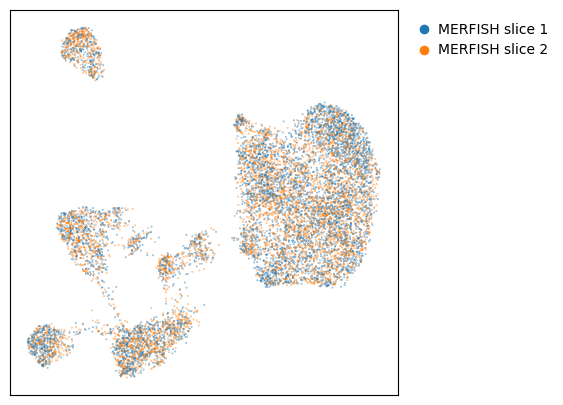

In [11]:
adata = adata_full

size = 0.05
umap = adata.obsm["X_umap"]
n_cells = umap.shape[0]
np.random.seed(1234)
order = np.arange(n_cells)
np.random.shuffle(order)

adata.obs["slice_color"] = ""
adata.obs["slice_color"][adata.obs["slice"].values.astype(str) == str(0)] = "tab:blue"
adata.obs["slice_color"][adata.obs["slice"].values.astype(str) == str(1)] = "tab:orange"

f = plt.figure(figsize=(5,5))

ax3 = f.add_subplot(1,1,1)
scatter2 = ax3.scatter(umap[order, 0], umap[order, 1], s=size, c=adata.obs["slice_color"][order], rasterized=True, marker='o')
ax3.tick_params(axis='both',bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False, grid_alpha=0)

legend_elements_slice = [Line2D([0], [0], marker='o', color="w", label='MERFISH slice 1', markerfacecolor="tab:blue", markersize=10),
                         Line2D([0], [0], marker='o', color="w", label='MERFISH slice 2', markerfacecolor="tab:orange", markersize=10)]
ax3.legend(handles=legend_elements_slice, loc="upper left", bbox_to_anchor=(1, 1.), frameon=False,
           markerscale=.8, fontsize=10, handletextpad=0., ncol=1)

f.subplots_adjust(hspace=0.02, wspace=0.1)
plt.show()

### Porportions of spatial factors visualized on spot representations

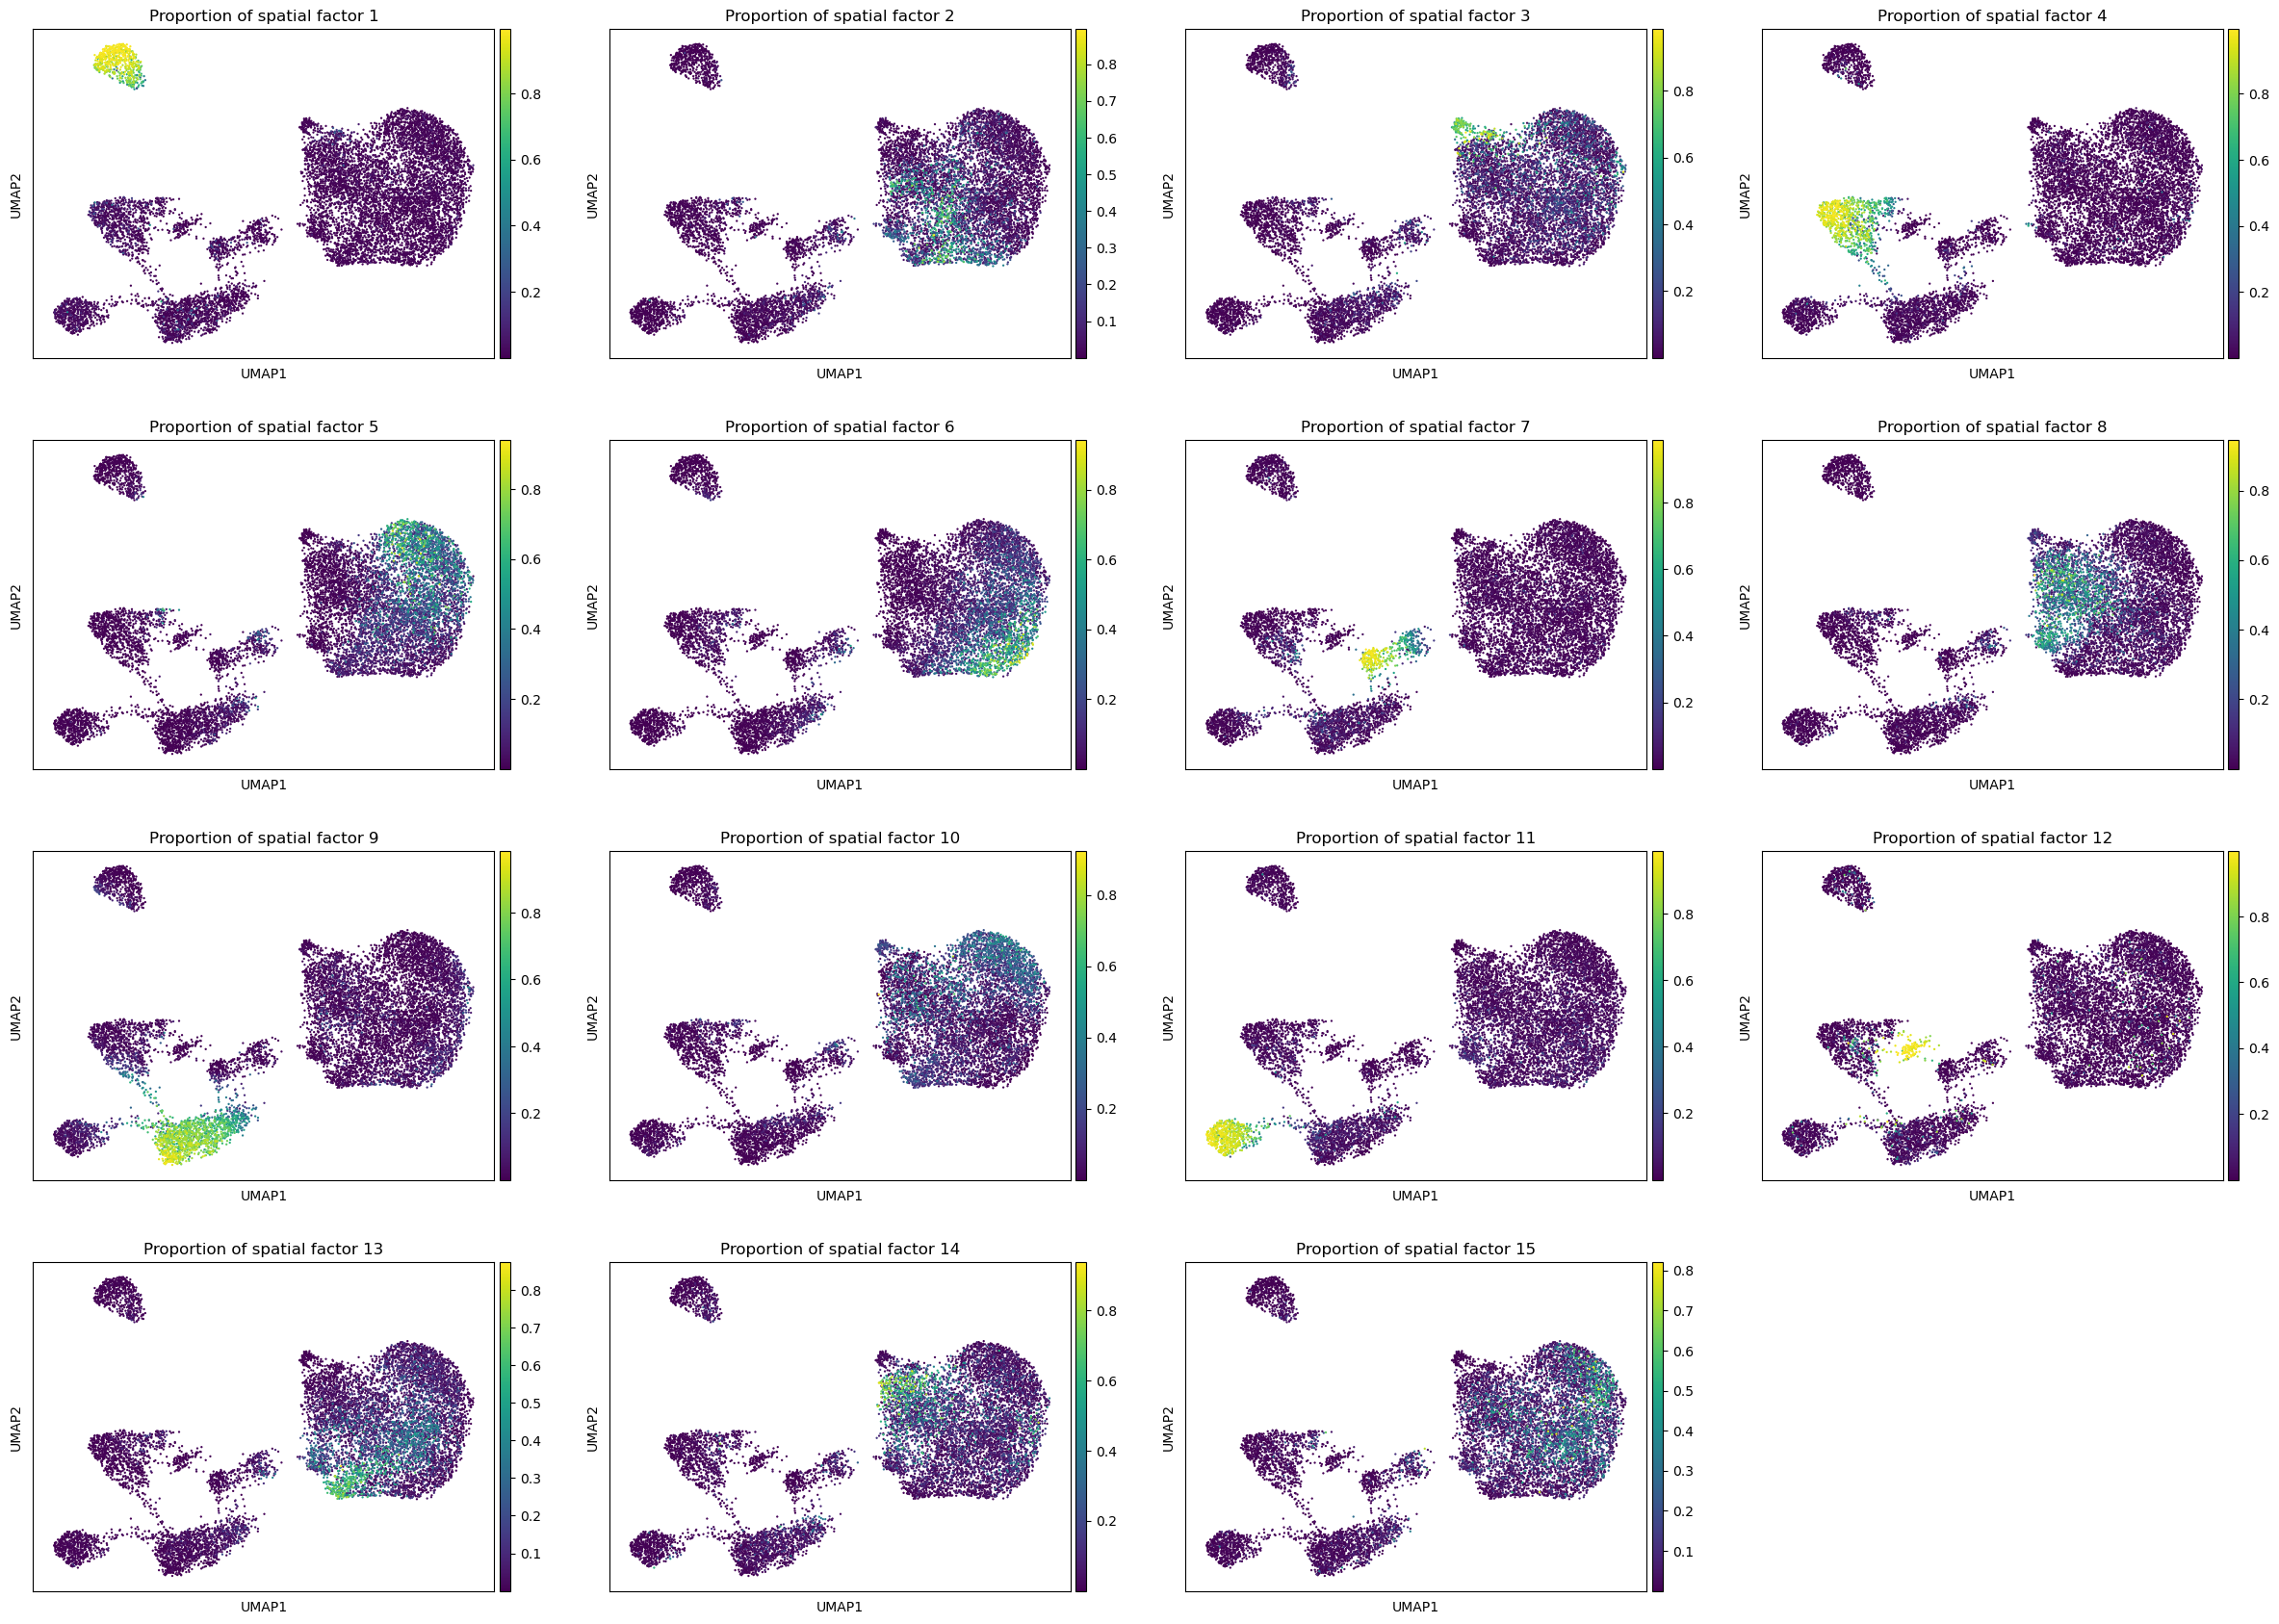

In [12]:
sc.pl.umap(adata_full, color=["Proportion of spatial factor "+str(i+1) for i in range(15)])

### Save results

In [13]:
res_path = "Results/INSPIRE_registration_merfish"
adata_full.write(res_path + "/adata_inspire.h5ad")
basis_df.to_csv(res_path + "/basis_df_inspire.csv")